In [ ]:
import os 
import cv2 # procesamiento de imagenes
import numpy as np
import matplotlib.pyplot as plt

Definimos el tamaño de nuestra imagen de 28x28, nuestro numero de entrada sera de 784 y tendremos una capa oculta de 128 neuronas y nuestro numeor de salidas sera de 3 por que en nuestro caso vamos a clasificar cocido, crudo o dañados de la fruta de PAPAYA

In [48]:
# 🔹 Tamaño de imagen
IMG_SIZE = 28

# 🔹 Hiperparámetros
num_entrada = IMG_SIZE * IMG_SIZE  # 28x28 = 784
num_oculta = 64
num_oculta2 = 32
num_salida = 3  # Tres clases

In [49]:
# 🔹 Función para cargar imágenes
def cargar_datos(directorio):
    X, Y = [], [] # Listas para almacenar imágenes y etiquetas
    clases = {clase: i for i, clase in enumerate(os.listdir(directorio))}  # Asigna etiquetas

    for clase, etiqueta in clases.items():
        path_clase = os.path.join(directorio, clase)

        for archivo in os.listdir(path_clase):
            img_path = os.path.join(path_clase, archivo)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img.flatten() / 255.0  # Normalizar

            X.append(img)
            Y.append(etiqueta)

    return np.array(X), np.array(Y)

ONE HOT ENCODING

que es una técnica para convertir etiquetas categóricas en vectores binarios. Esto es útil en problemas de clasificación, ya que las redes neuronales trabajan mejor con representaciones numéricas.

In [ ]:
# vectores binarios
# 🔹 One-hot encoding
def one_hot(Y, num_clases):
    return np.eye(num_clases)[Y]  #[1,0,0] -> [0,1,0] -> [0,0,1]

In [51]:
# 🔹 Inicialización de pesos
def init_pesos():
    W1 = np.random.randn(num_entrada, num_oculta) * 0.01
    b1 = np.zeros((1, num_oculta))
    W2 = np.random.randn(num_oculta, num_oculta2) * 0.01
    b2 = np.zeros((1, num_oculta2))
    W3 = np.random.randn(num_oculta2, num_salida) * 0.01
    b3 = np.zeros((1, num_salida))
    return W1, b1, W2, b2, W3, b3

In [52]:
# Llamada a la función init_pesos
W1, b1, W2, b2, W3, b3 = init_pesos()

# Imprimir los pesos y sesgos
print("W1:", W1)
print("b1:", b1)
print("W2:", W2)
print("b2:", b2)
print("W3:", W3)
print("b3:", b3)

W1: [[ 0.0109863  -0.00138456 -0.01751731 ...  0.0042083  -0.00138965
   0.01166751]
 [ 0.00088651  0.00865139  0.017798   ... -0.00326123  0.00490502
  -0.0116353 ]
 [-0.00273389  0.00885824 -0.007843   ...  0.00676623 -0.0073996
  -0.00673956]
 ...
 [-0.00338382 -0.00674862 -0.00188446 ...  0.00671039  0.00819648
   0.00275901]
 [-0.00099292 -0.01206171 -0.00751625 ... -0.0006656  -0.01143221
  -0.00439576]
 [ 0.00906323 -0.01194618  0.00998711 ...  0.01646511  0.02824435
  -0.0032942 ]]
b1: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
W2: [[ 0.01125261 -0.00973254 -0.01431893 ... -0.00622728 -0.00570358
   0.00239654]
 [-0.00748199 -0.00752051 -0.0124362  ...  0.00357405 -0.00640877
   0.00556227]
 [-0.0147787  -0.00759057  0.00452615 ...  0.01274199 -0.01052457
   0.00966018]
 ...
 [-0.00330743  0.01359904  0.00173623 ...  0.0051

FUNCIONES DE ACTIVACION Y FUNCION PARA VALIDACION

In [53]:
# 🔹 Funciones de activación
def relu(Z):
    return np.maximum(0, Z)

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True)) # exponencial de Z
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True) # exponencial de Z / suma exponencial de Z

# 🔹 Función de pérdida (Categorical Crossentropy)
def cross_entropy_loss(Y_true, Y_pred):
    return -np.mean(Y_true * np.log(Y_pred + 1e-8)) 

# Evaluacion
def accuracy_score_manual(y_true, y_pred):
    """
    Calcula la precisión de un modelo comparando las etiquetas verdaderas con las predicciones.
    
    Parámetros:
        y_true (numpy array): Etiquetas reales (shape: (n_samples,))
        y_pred (numpy array): Etiquetas predichas (shape: (n_samples,))

    Retorna:
        float: Precisión del modelo (entre 0 y 1)
    """
    return np.mean(y_true == y_pred) 


RETROPROPAGACION
se halla el error en la capa de salida y teniendo eso valor se halla las gradientes y se propaga por toda la red


In [54]:

# 🔹 Retropropagación para una red con dos capas ocultas
def backward(X, Y, A1, A2, A3, W2, W3):
    m = X.shape[0]  # Número de ejemplos

    # 🔹 Error en la capa de salida (derivada de la función de costo respecto a A3)
    dZ3 = A3 - Y  

    # 🔹 Gradientes de la capa de salida
    dW3 = np.dot(A2.T, dZ3) / m  # Gradiente de los pesos de la capa de salida normalizado
    db3 = np.sum(dZ3, axis=0, keepdims=True) / m 

    # 🔹 Propagación del error hacia la segunda capa oculta
    dA2 = np.dot(dZ3, W3.T)  # Propagamos el error hacia A2
    dZ2 = dA2 * (A2 > 0)  # Aplicamos la derivada de ReLU

    # 🔹 Gradientes de la segunda capa oculta
    dW2 = np.dot(A1.T, dZ2) / m  # Gradiente de los pesos de la segunda capa oculta
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m 

    # 🔹 Propagación del error hacia la primera capa oculta
    dA1 = np.dot(dZ2, W2.T)  # Propagamos el error hacia A1
    dZ1 = dA1 * (A1 > 0)  # Aplicamos la derivada de ReLU

    # 🔹 Gradientes de la primera capa oculta
    dW1 = np.dot(X.T, dZ1) / m  # Gradiente de los pesos de la primera capa oculta
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    return dW1, db1, dW2, db2, dW3, db3


In [55]:
# 🔹 Predicción
def predecir(X, W1, b1, W2, b2, W3, b3):
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = relu(Z2)
    Z3 = np.dot(A2, W3) + b3
    A3 = softmax(Z3)
    return np.argmax(A3, axis=1)

ENTRENAMIENTO

In [56]:
# 🔹 Entrenamiento
def entrenar(X, Y, X_val, Y_val, epochs=9000, lr=0.005):
    W1, b1, W2, b2, W3, b3 = init_pesos()
    losses = []
    accuracies = []

    for epoch in range(epochs):
        # Forward
        Z1 = np.dot(X, W1) + b1
        A1 = relu(Z1)
        Z2 = np.dot(A1, W2) + b2
        A2 = relu(Z2)
        Z3 = np.dot(A2, W3) + b3
        A3 = softmax(Z3)

        # Cálculo de pérdida
        # loss = -np.mean(Y * np.log(A2 + 1e-8))
        loss = cross_entropy_loss(Y, A3 + 1e-8)
        losses.append(loss)

        # Backpropagation
        dW1, db1, dW2, db2, dW3, db3 = backward(X, Y, A1, A2, A3, W2, W3)

        # Actualización de pesos
        W1 -= lr * dW1
        b1 -= lr * db1
        W2 -= lr * dW2
        b2 -= lr * db2
        W3 -= lr * dW3
        b3 -= lr * db3


        Y_pred_val = predecir(X_val, W1, b1, W2, b2, W3, b3)
        accuracy_val = accuracy_score_manual(Y_val, Y_pred_val)
        accuracies.append(accuracy_val)


        # Mostrar pérdida cada 10 épocas
        if epoch % 100 == 0:
            print(f"Época {epoch}, Pérdida: {loss:.4f}, Precisión: {accuracy_val:.4f}")
        
    # 🔹 Graficar pérdida y precisión en el mismo gráfico
    epochs_range = range(len(losses))

    fig, ax1 = plt.subplots(figsize=(8, 5))

    # 📉 Graficar la pérdida (eje izquierdo)
    ax1.plot(epochs_range, losses, label="Pérdida", color="blue", linestyle="--", marker="o")
    ax1.set_xlabel("Épocas")
    ax1.set_ylabel("Loss", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")

    # 📈 Graficar la precisión en el eje derecho
    ax2 = ax1.twinx()
    ax2.plot(epochs_range, accuracies, label="Precisión", color="orange", linestyle="-", marker="s")
    ax2.set_ylabel("Accuracy", color="orange")
    ax2.tick_params(axis="y", labelcolor="orange")

    # Títulos y leyenda
    plt.title("Evolución de la Pérdida y Precisión")
    fig.legend(loc="upper right", bbox_to_anchor=(0.85, 0.85))

    plt.show()

    return W1, b1, W2, b2, W3, b3

In [57]:
# 🔹 Cargar datos y entrenar
#clases = ['cocidos', 'crudos', 'dañados']
X_train, Y_train = cargar_datos("D:/SIS-421/DATASET_PAPAYA/TRAIN")
X_val, Y_val = cargar_datos("D:/SIS-421/DATASET_PAPAYA/VALIDATION")

In [58]:
# Convertir etiquetas a one-hot encoding
Y_train_one_hot = one_hot(Y_train, num_salida)
Y_val_one_hot = one_hot(Y_val, num_salida)

Época 0, Pérdida: 0.3662, Precisión: 0.3639
Época 100, Pérdida: 0.3662, Precisión: 0.3417
Época 200, Pérdida: 0.3662, Precisión: 0.3444
Época 300, Pérdida: 0.3662, Precisión: 0.3528
Época 400, Pérdida: 0.3662, Precisión: 0.3639
Época 500, Pérdida: 0.3662, Precisión: 0.3694
Época 600, Pérdida: 0.3662, Precisión: 0.3639
Época 700, Pérdida: 0.3662, Precisión: 0.3806
Época 800, Pérdida: 0.3662, Precisión: 0.4000
Época 900, Pérdida: 0.3662, Precisión: 0.4361
Época 1000, Pérdida: 0.3662, Precisión: 0.4306
Época 1100, Pérdida: 0.3662, Precisión: 0.4250
Época 1200, Pérdida: 0.3662, Precisión: 0.4278
Época 1300, Pérdida: 0.3662, Precisión: 0.4222
Época 1400, Pérdida: 0.3662, Precisión: 0.4222
Época 1500, Pérdida: 0.3662, Precisión: 0.4194
Época 1600, Pérdida: 0.3662, Precisión: 0.4333
Época 1700, Pérdida: 0.3662, Precisión: 0.4333
Época 1800, Pérdida: 0.3662, Precisión: 0.4417
Época 1900, Pérdida: 0.3662, Precisión: 0.4389
Época 2000, Pérdida: 0.3662, Precisión: 0.4444
Época 2100, Pérdida: 0.36

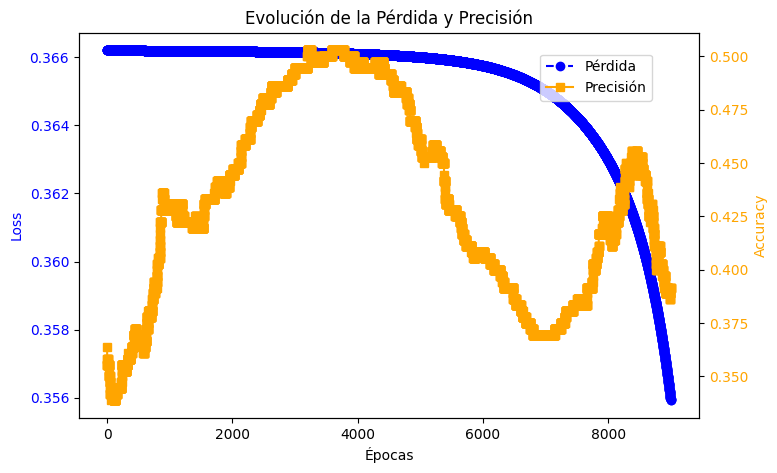

In [59]:
# Entrenar el MLP
W1, b1, W2, b2, W3, b3 = entrenar(X_train, Y_train_one_hot, X_val, Y_val)

In [60]:
# # Evaluación en validación
# Y_pred = predecir(X_val, W1, b1, W2, b2)
# accuracy = np.mean(Y_pred == Y_val)
# print(f"Precisión en validación: {accuracy:.2%}")

MATRIZ DE CONFUSION

Precisión en test: 39.44%


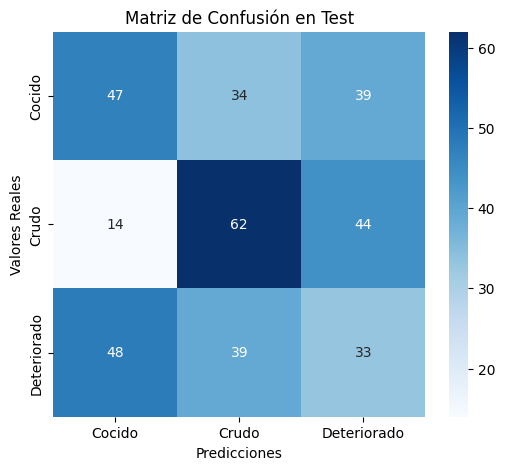

In [62]:
from sklearn.metrics import accuracy_score, confusion_matrix

import seaborn as sns

# 🔹 Cargar datos de prueba
X_test, Y_test = cargar_datos("D:/SIS-421/DATASET_PAPAYA/TEST")

# 🔹 Predecir en el conjunto de prueba
Y_pred_test = predecir(X_test, W1, b1, W2, b2, W3, b3)

# 🔹 Calcular precisión
accuracy_test = accuracy_score(Y_test, Y_pred_test)
print(f"Precisión en test: {accuracy_test:.2%}")

# 🔹 Matriz de Confusión
conf_matrix = confusion_matrix(Y_test, Y_pred_test)

# 🔹 Graficar Matriz de Confusión
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Cocido", "Crudo", "Deteriorado"], yticklabels=["Cocido", "Crudo", "Deteriorado"])
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión en Test")
plt.show()


CONCLUSIONES DEL ENTRENAMIENTO

El modelo no está aprendiendo correctamente las características de cada clase.

El modelo tiende a predecir "clase 1" más de lo debido.

Probablemente necesite mejor entrenamiento:

-Aumentar datos de entrenamiento.

-Revisar la normalización de imágenes.

-Ajustar la tasa de aprendizaje o número de epochs.

-Revisar la arquitectura del MLP (número de capas/neuronas).